<div class="alert alert-success"> Week 5 -- Steiner</div>
<br>  Develop an analytical question, define new features, then do a Random forest
<p>
<p> Data set being used is from https://catalog.data.gov/dataset/u-s-chronic-disease-indicators  
    <br>  data set has had a preliminary cleaning.

In [2]:
PYDEVD_DISABLE_FILE_VALIDATION=1

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#import the sql package
from sqlalchemy import create_engine

In [10]:
#set up variable for the db
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db for this class
user = r'postgres' # using the postgres user because I'm too lazy to create a new one
pw = r'BrightBlessings1!' # this is the password established during installation
port = r'5432' # default port estabalished during install
schema = r'cleaned' # schema where I last saved the data to

In [12]:
#open the connection
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [14]:
#read from the table created

table_name = r'\disease_cleaned'
schema = r'cleaned' # schema were the data was loaded last week.

df = pd.read_sql_table(table_name, db_conn, schema)
disease=df

In [16]:
disease.head(10)

,YearStart,YearEnd,LocationAbbr,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueFootnote,StratificationCategory1,Stratification1,QuestionID,DataValueTypeID
0,2019,2019,AR,BRFSS,Diabetes,Diabetes among adults,%,Crude Prevalence,13.6,None,Sex,Male,DIA01,CRDPREV
1,2019,2019,ID,BRFSS,Diabetes,Diabetes among adults,%,Crude Prevalence,10.6,None,Sex,Male,DIA01,CRDPREV
2,2019,2019,IN,YRBSS,Sleep,Short sleep duration among high school students,%,Crude Prevalence,0.0,No data available,Grade,Grade 12,SLP02,CRDPREV
3,2019,2019,IA,NVSS,Asthma,"Asthma mortality among all people, underlying ...",Number,Number,54.0,None,Overall,Overall,AST01,NMBR
4,2019,2019,IA,BRFSS,Asthma,Current asthma among adults,%,Crude Prevalence,10.3,None,Age,Age 18-44,AST02,CRDPREV
5,2019,2019,IA,NVSS,Diabetes,"Diabetes mortality among all people, underlyin...",Number,Number,54.0,None,Age,Age 0-44,DIA03,NMBR
6,2019,2019,IA,BRFSS,Health Status,Recent activity limitation among adults,Number,Crude Mean,2.3,None,Sex,Female,HEA04,CRDMEAN
7,2019,2019,IA,BRFSS,Mental Health,Depression among adults,%,Crude Prevalence,31.0,None,Race/Ethnicity,"Multiracial, non-Hispanic",MEN02,CRDPREV
8,2019,2019,KS,NVSS,Diabetes,"Diabetes mortality among all people, underlyin...",Number,Number,524.0,None,Age,Age 45-64,DIA03,NMBR
9,2019,2019,LA,BRFSS,Mental Health,Depression among adults,%,Crude Prevalence,29.3,None,Race/Ethnicity,Hispanic,MEN02,CRDPREV


In [17]:
disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309215 entries, 0 to 309214
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   YearStart                309215 non-null  int64  
 1   YearEnd                  309215 non-null  int64  
 2   LocationAbbr             309215 non-null  object 
 3   DataSource               309215 non-null  object 
 4   Topic                    309215 non-null  object 
 5   Question                 309215 non-null  object 
 6   DataValueUnit            309215 non-null  object 
 7   DataValueType            309215 non-null  object 
 8   DataValue                309215 non-null  float64
 9   DataValueFootnote        309215 non-null  object 
 10  StratificationCategory1  309215 non-null  object 
 11  Stratification1          309215 non-null  object 
 12  QuestionID               309215 non-null  object 
 13  DataValueTypeID          309215 non-null  object 
dtypes: f

Yup, still got data.  I think that the data set is still a little too robust and trimming the redundant columns will be helpful

In [21]:
dis=disease[["YearStart", "YearEnd","LocationAbbr","Topic","Question","DataValue","DataValueFootnote","StratificationCategory1","Stratification1","QuestionID", "DataValueTypeID"]]

This dataset leveraged using a single feature for multiple data types, meaning that a single feature may mean several different things depending on the value in another field--i.e. StratificationCategory1=sex, Stratification1=female.  While it makes it hard to 'read' the data without working at it, it also allows for using get_dummies to break the data apart.

<p><p>
Before getting too far, I want to see what topics we have to work with.

In [24]:
dis['Topic'].value_counts()

Topic
Cardiovascular Disease                             30709
Chronic Obstructive Pulmonary Disease              26951
Nutrition, Physical Activity, and Weight Status    26069
Health Status                                      25612
Alcohol                                            25321
Cancer                                             22358
Immunization                                       19140
Social Determinants of Health                      19026
Arthritis                                          18645
Diabetes                                           17318
Mental Health                                      16976
Tobacco                                            15931
Oral Health                                        13236
Asthma                                             10511
Cognitive Health and Caregiving                     9904
Sleep                                               5318
Disability                                          5060
Maternal Health          

<div class="alert alert-success">At this point, we should define a analytical question to guide your investigation.</div>
<p>I'm choosing to reduce this dataset a bit.  I'm going to look at just CardioVascular Disease, rather than all of the topics.
<p>  I will need to do some more data prep before I can set up the random forest.
<p><p>
    Analytical Question:  Is it possible to predict Cardio Vascular disease using the data points from the chronic illness data file?

In [27]:
df1 = dis.loc[dis['Topic'] == 'Cardiovascular Disease']
df1.head()

,YearStart,YearEnd,LocationAbbr,Topic,Question,DataValue,DataValueFootnote,StratificationCategory1,Stratification1,QuestionID,DataValueTypeID
7430,2019,2019,US,Cardiovascular Disease,Coronary heart disease mortality among all peo...,147536.00,None,Sex,Female,CVD08,NMBR
14257,2019,2019,AK,Cardiovascular Disease,Diseases of the heart mortality among all peop...,159.70,None,Sex,Male,CVD09,AGEADJRATE
14272,2019,2019,AK,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,99.00,None,Sex,Male,CVD07,NMBR
14313,2019,2019,CA,Cardiovascular Disease,Taking medicine to control high blood pressure...,47.20,None,Race/Ethnicity,"Multiracial, non-Hispanic",CVD02,AGEADJPREV
14316,2019,2019,AL,Cardiovascular Disease,Hospitalization for heart failure as principal...,71.43,None,Race/Ethnicity,"American Indian or Alaska Native, non-Hispanic",CVD06,CRDRATE


Okay, we can trim the data down just a little more 

In [30]:
dis1=df1[["YearStart", "YearEnd","LocationAbbr","DataValue","StratificationCategory1","Stratification1","QuestionID", "DataValueTypeID"]]

Okay--I had tried to do the random tree by doing just the get dummies and it errored.  I decided to go ahead and seperate out the stratification category to their own columns, and using N/A as the value where it didn't apply.  I did get a warning, but it did create the new columns, so I'm running with it.

In [33]:
dis1['gender'] = np.where(dis1['StratificationCategory1'] == 'Sex', dis1['Stratification1'], 'N/A')

In [35]:
dis1.head()

,YearStart,YearEnd,LocationAbbr,DataValue,StratificationCategory1,Stratification1,QuestionID,DataValueTypeID,gender
7430,2019,2019,US,147536.00,Sex,Female,CVD08,NMBR,Female
14257,2019,2019,AK,159.70,Sex,Male,CVD09,AGEADJRATE,Male
14272,2019,2019,AK,99.00,Sex,Male,CVD07,NMBR,Male
14313,2019,2019,CA,47.20,Race/Ethnicity,"Multiracial, non-Hispanic",CVD02,AGEADJPREV,N/A
14316,2019,2019,AL,71.43,Race/Ethnicity,"American Indian or Alaska Native, non-Hispanic",CVD06,CRDRATE,N/A


In [37]:
dis1['StratificationCategory1'].value_counts()

StratificationCategory1
Race/Ethnicity    18328
Sex                5504
Age                4125
Overall            2752
Name: count, dtype: int64

In [39]:
dis1['Race'] = np.where(dis1['StratificationCategory1'] == 'Race/Ethnicity', dis1['Stratification1'], 'N/A')

In [41]:
dis1.head()

,YearStart,YearEnd,LocationAbbr,DataValue,StratificationCategory1,Stratification1,QuestionID,DataValueTypeID,gender,Race
7430,2019,2019,US,147536.00,Sex,Female,CVD08,NMBR,Female,N/A
14257,2019,2019,AK,159.70,Sex,Male,CVD09,AGEADJRATE,Male,N/A
14272,2019,2019,AK,99.00,Sex,Male,CVD07,NMBR,Male,N/A
14313,2019,2019,CA,47.20,Race/Ethnicity,"Multiracial, non-Hispanic",CVD02,AGEADJPREV,N/A,"Multiracial, non-Hispanic"
14316,2019,2019,AL,71.43,Race/Ethnicity,"American Indian or Alaska Native, non-Hispanic",CVD06,CRDRATE,N/A,"American Indian or Alaska Native, non-Hispanic"


In [43]:
dis1['Overall'] = np.where(dis1['StratificationCategory1'] == 'Overall', dis1['Stratification1'], 'N/A')

In [45]:
dis1.head()

,YearStart,YearEnd,LocationAbbr,DataValue,StratificationCategory1,Stratification1,QuestionID,DataValueTypeID,gender,Race,Overall
7430,2019,2019,US,147536.00,Sex,Female,CVD08,NMBR,Female,N/A,N/A
14257,2019,2019,AK,159.70,Sex,Male,CVD09,AGEADJRATE,Male,N/A,N/A
14272,2019,2019,AK,99.00,Sex,Male,CVD07,NMBR,Male,N/A,N/A
14313,2019,2019,CA,47.20,Race/Ethnicity,"Multiracial, non-Hispanic",CVD02,AGEADJPREV,N/A,"Multiracial, non-Hispanic",N/A
14316,2019,2019,AL,71.43,Race/Ethnicity,"American Indian or Alaska Native, non-Hispanic",CVD06,CRDRATE,N/A,"American Indian or Alaska Native, non-Hispanic",N/A


In [47]:
dis1['Age'] = np.where(dis1['StratificationCategory1'] == 'Age', dis1['Stratification1'], 'N/A')

In [49]:
dis1.head()

,YearStart,YearEnd,LocationAbbr,DataValue,StratificationCategory1,Stratification1,QuestionID,DataValueTypeID,gender,Race,Overall,Age
7430,2019,2019,US,147536.00,Sex,Female,CVD08,NMBR,Female,N/A,N/A,N/A
14257,2019,2019,AK,159.70,Sex,Male,CVD09,AGEADJRATE,Male,N/A,N/A,N/A
14272,2019,2019,AK,99.00,Sex,Male,CVD07,NMBR,Male,N/A,N/A,N/A
14313,2019,2019,CA,47.20,Race/Ethnicity,"Multiracial, non-Hispanic",CVD02,AGEADJPREV,N/A,"Multiracial, non-Hispanic",N/A,N/A
14316,2019,2019,AL,71.43,Race/Ethnicity,"American Indian or Alaska Native, non-Hispanic",CVD06,CRDRATE,N/A,"American Indian or Alaska Native, non-Hispanic",N/A,N/A


Okay--now I can create a new df using the new columns

In [54]:
df=dis1[["YearStart", "YearEnd","LocationAbbr", "DataValueTypeID","DataValue","QuestionID","gender","Race","Overall","Age"]]

I'm filtering the data down to just the Us.  The state by state is too large to be useful.  

In [57]:
dfa = df.loc[df['LocationAbbr'] == 'US']

In [59]:
df=dfa

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577 entries, 7430 to 260766
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearStart        577 non-null    int64  
 1   YearEnd          577 non-null    int64  
 2   LocationAbbr     577 non-null    object 
 3   DataValueTypeID  577 non-null    object 
 4   DataValue        577 non-null    float64
 5   QuestionID       577 non-null    object 
 6   gender           577 non-null    object 
 7   Race             577 non-null    object 
 8   Overall          577 non-null    object 
 9   Age              577 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 49.6+ KB


Change the text values to int

In [66]:
df['Race'].value_counts()

Race
N/A                                               231
Hispanic                                           52
American Indian or Alaska Native, non-Hispanic     52
White, non-Hispanic                                52
Black, non-Hispanic                                52
Asian, non-Hispanic                                43
Hawaiian or Pacific Islander, non-Hispanic         43
Multiracial, non-Hispanic                          43
Asian or Pacific Islander, non-Hispanic             9
Name: count, dtype: int64

In [68]:
df['gender'] = df['gender'].replace({'N/A': 0, 'Female': 1,'Male': 2})

In [70]:
df['Race'] = df['Race'].replace({'N/A': 0, 'American Indian or Alaska Native, non-Hispanic': 1,'Black, non-Hispanic': 2,'White, non-Hispanic': 3, 'Hispanic':4, 'Multiracial, non-Hispanic': 5, 'Hawaiian or Pacific Islander, non-Hispanic': 6,'Asian, non-Hispanic': 7, 'Asian or Pacific Islander, non-Hispanic':8 })

In [72]:
df['Age'].value_counts()

Age
N/A          502
Age 45-64     25
Age >=65      25
Age 0-44      18
Age 18-44      7
Name: count, dtype: int64

In [74]:
df['Age'] = df['Age'].replace({'N/A': 0, 'Age 18-44': 1,'Age 0-44': 2,'Age 45-64':3, 'Age >=65': 4})

In [76]:
df['QuestionID'].value_counts()

QuestionID
CVD08    108
CVD07    108
CVD09    108
CVD06     72
CVD03     46
CVD02     46
CVD04     46
CVD01     43
Name: count, dtype: int64

In [78]:
df['QuestionID'] = df['QuestionID'].replace({'CVD01': 0, 'CVD02': 1,'CVD03': 2,'CVD04':3, 'CVD06': 4, 'CVD07': 5, 'CVD08': 6, 'CVD09': 7})

In [80]:
df['Overall'].value_counts()

Overall
N/A        525
Overall     52
Name: count, dtype: int64

In [82]:
df['Overall'] = df['Overall'].replace({'N/A': 0, 'Overall': 1})

In [84]:
df['DataValueTypeID'].value_counts()

DataValueTypeID
NMBR          141
CRDRATE       141
AGEADJRATE    114
CRDPREV       101
AGEADJPREV     80
Name: count, dtype: int64

In [85]:
df['DataValueTypeID'] = df['DataValueTypeID'].replace({'NMBR': 0, 'CRDRATE': 1,'AGEADJRATE': 2,'CRDPREV':3, 'AGEADJPREV': 4})

In [88]:
df['LocationAbbr'] = df['LocationAbbr'].replace({'US': 0})

In [90]:
df2=df

In [92]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577 entries, 7430 to 260766
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearStart        577 non-null    int64  
 1   YearEnd          577 non-null    int64  
 2   LocationAbbr     577 non-null    int64  
 3   DataValueTypeID  577 non-null    int64  
 4   DataValue        577 non-null    float64
 5   QuestionID       577 non-null    int64  
 6   gender           577 non-null    int64  
 7   Race             577 non-null    int64  
 8   Overall          577 non-null    int64  
 9   Age              577 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 49.6 KB


### Manual Features
I had thought to do a ratio by state--meaning State/US, however it looks like that may not work the way I had wanted it to.  
There's really not much else I can do a manual feature with.


In [95]:
df2.columns = df2.columns.map(str)

In [97]:
# Splitting the dataset
X = df2.drop(columns=['gender'])  # Dropping one-hot target columns
y = df2['gender']  # Binary classification for example purposes

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
# Train a model and analyze feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

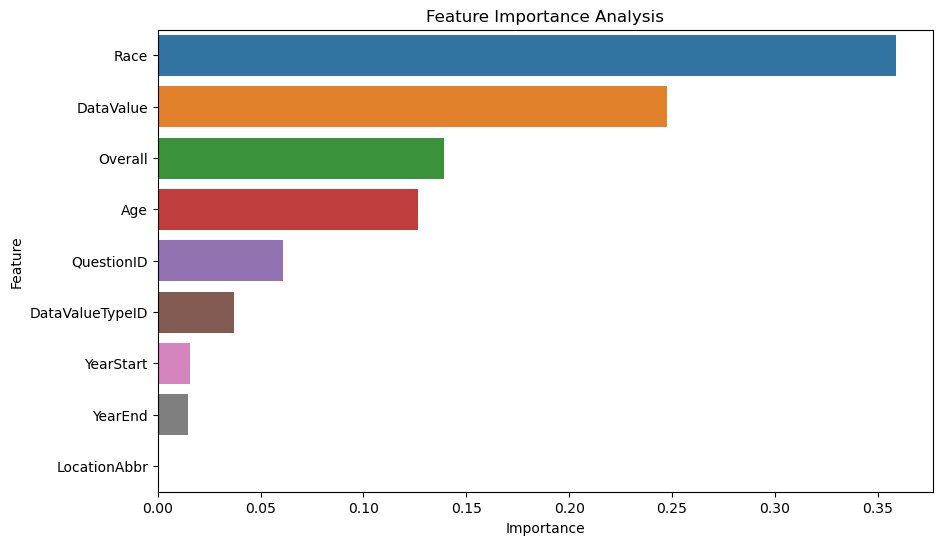

In [103]:
# Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance Analysis")
plt.show()

Create the actual tree

In [111]:
features = df2.drop('Race', axis=1)
targets = df2['Race']

In [113]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=42)

In [115]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

0.9513888888888888
0.7379310344827587


In [117]:
dt.get_depth()

22

Wow--I wasn't expecting it to have that depth!  Let's plot it anyway, just to see what it looks like

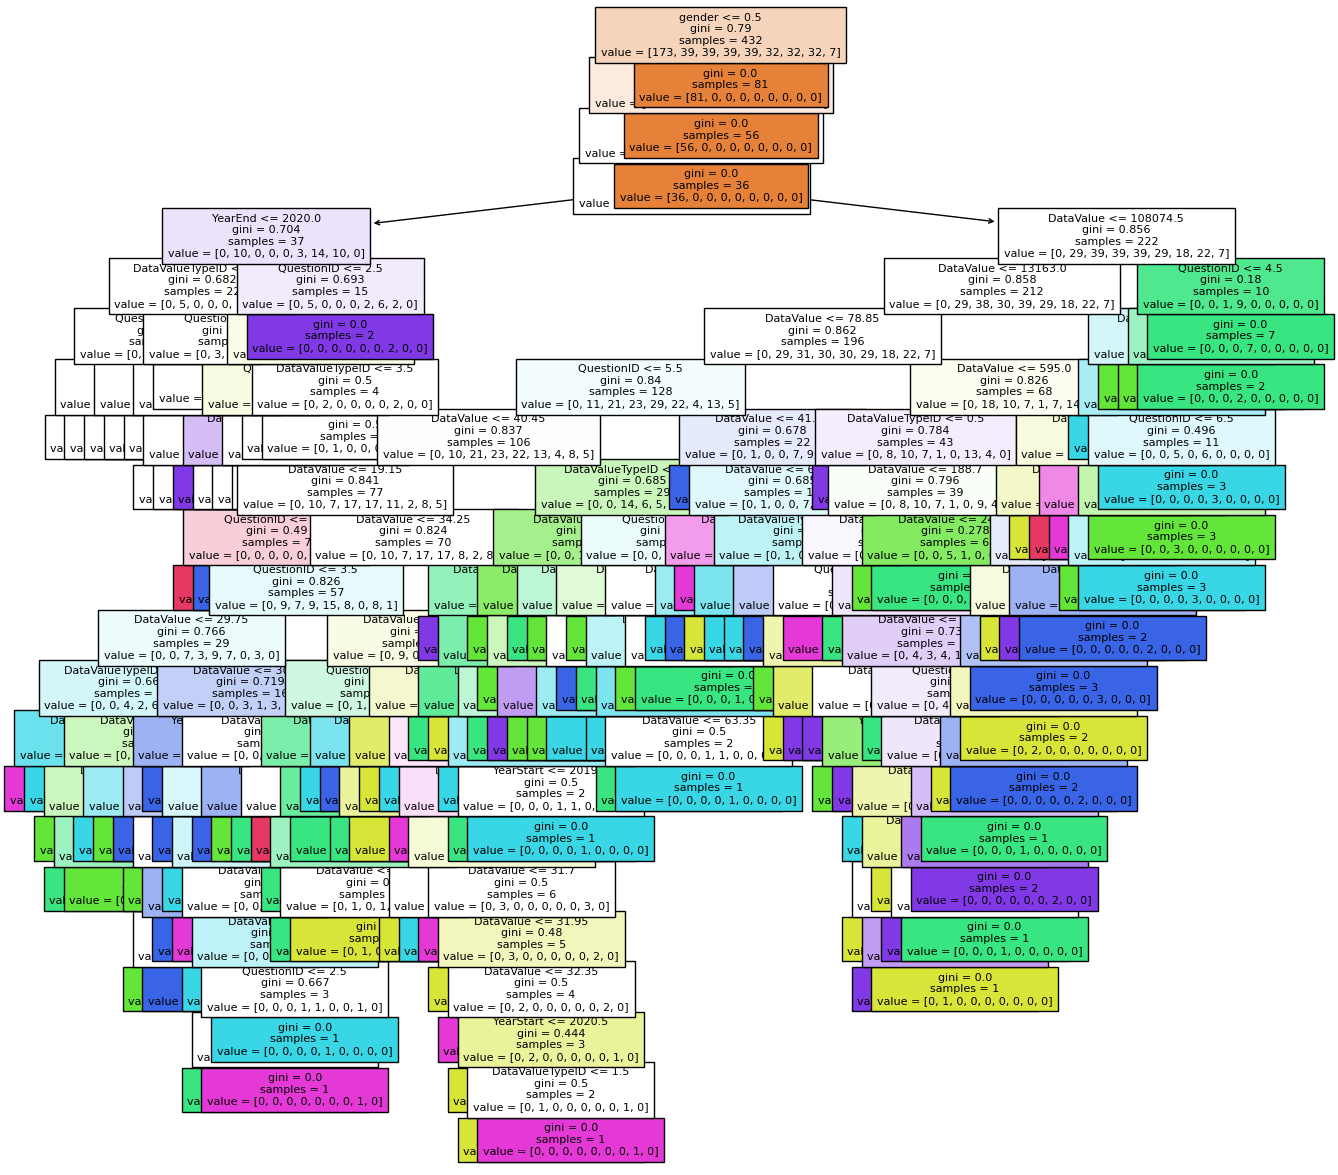

In [119]:
f = plt.figure(figsize=(15, 15))
_ = plot_tree(dt, fontsize=8, feature_names=features.columns, filled=True)

In [121]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(x_train, y_train)

print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

0.5486111111111112
0.496551724137931


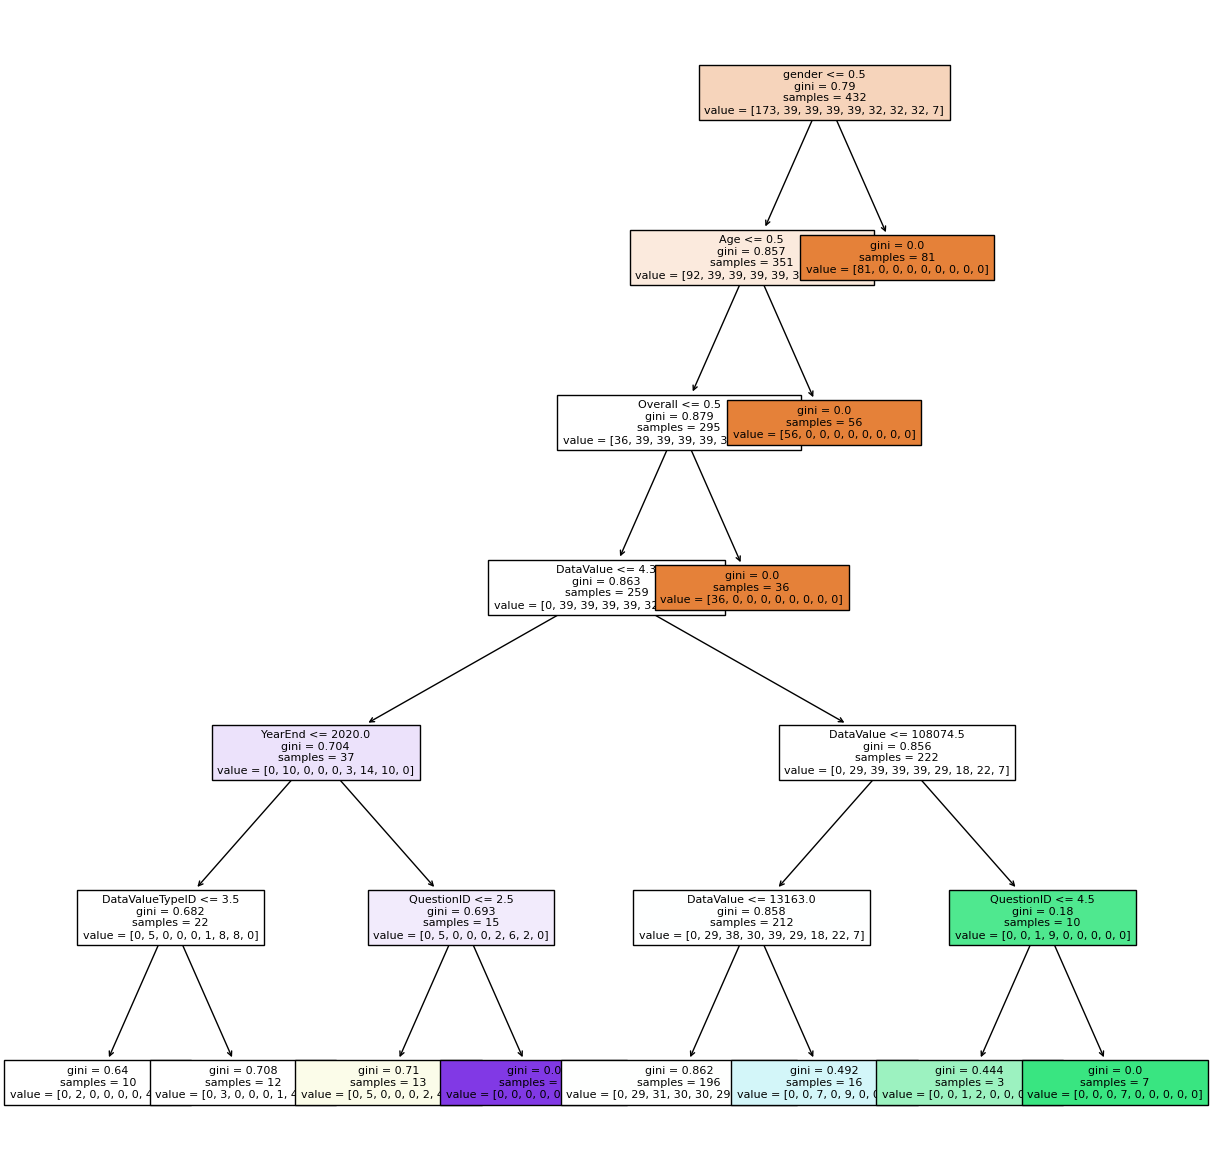

In [123]:
f = plt.figure(figsize=(15, 15))
_ = plot_tree(dt, fontsize=8, feature_names=features.columns, filled=True)

In [132]:
table_name = r'tree'
schema = r'cleaned' # schema we created this week.

df2.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

577

<div class="alert alert-success"> </div><b>Analysis:</b><br> How did your new features do? <br> Are there other ways to evaluate the impact of your new features? 
<br>Do you need to do anything to guard against overfitting from redundant information?</div>

I had several challenges with the dataset.  When I used get dummies, the resulting graph was unreadable.  I went back through all of the features and gave them numerical values so the end result was not overwhelming.
<p>
After I flattened and converted everything, I found I had an issue with the column names and needed to change them to str.  That also took some doing as what I found online suggested changing a config file I don't have.  I found a valid fix on Kaggle.  
<p>
Once all of that was fixed, I was able to run the importance graph. Race appears to be top of the list for feature importance.  
    <br> I did notice within the data that Question COVD_5 is missing from the data.  I also noticed that there is an overlap in age data--0-44 and 18-44.  <br> I think the mehodolgy I've chosen could be workable with the full data set.  It will just take time.
    <p>
        
        References:
        <br>  Previous assignments from other classes.
        <br> https://www.kaggle.com/discussions/questions-and-answers/401490
